The data here from Clear sky irradiance data and also the power is converted by using clear sky
In other words no cloud data are included in the modeling. 
So the NCF is for the best outcome of PV.

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# naive_times = pd.DatetimeIndex(start='2017', end='2018', freq='1h')
# naive_times = pd.DatetimeIndex(start='2018', end='2019', freq='1h')
naive_times = pd.DatetimeIndex(start='2009', end='2010', freq='1h')
# naive_times = pd.DatetimeIndex(start='2010', end='2011', freq='1h')  
####For different years the results are changing slightly (not significant)


# very approximate
# latitude, longitude, name, altitude, timezone
coordinates = [(35.2, -80.8, 'Charlotte', 232, 'Etc/GMT+4'),
(40, -105.3, 'Boulder', 1624, 'Etc/GMT+6'),
(42.3, -71.2, 'Boston', 43, 'Etc/GMT+4'),
(30, -110, 'Tucson', 700, 'Etc/GMT+7')]

import pvlib

# get the module and inverter specifications from SAM
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')

sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']

inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208_208V__CEC_2014_']

# specify constant ambient air temp and wind for simplicity
temp_air = 20

wind_speed = 0

In [33]:
system = {'module': module, 'inverter': inverter,
           'surface_azimuth': 180}
# system
# module

In [46]:
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.tracking import SingleAxisTracker

# ##### This is for 300*15=990,000W about 1MW  (doesn't work)
# system = {'module': module, 'inverter': inverter,
#            'surface_azimuth': 180,
#             modules_per_string=15,
#             strings_per_inverter=300}

##### This is for 300*15=990,000W about 1MW solar PV plant and single tracker

# system = SingleAxisTracker(module_parameters=module,
#                                inverter_parameters=inverter,
#                                modules_per_string=15,
#                                strings_per_inverter=300)
# system

# system=pvlib.pvsystem.PVSystem(surface_tilt=22.5,
#                         surface_azimuth=180,
#                         albedo=.2,
#                         modules_per_string=30,
#                         strings_per_inverter=100,
#                         module_parameters=module,
#                         inverter_parameters=inverter,
#                         name=location.name)
# system


#########I thik its more easier just changed the ac power lines of the system capacity 
#########in the below cell to get this 1 MW (rather than string argument in systme)

In [47]:
energies = {}
ac_locs = {}
NCF = {}  #Net Capacity Factor: Divide sum of generation by the number of periods times the system size
# NCF_monthly=pd.DataFrame(columns=[list(range(len(coordinates)))])
NCF_monthly={}


for latitude, longitude, name, altitude, timezone in coordinates:
        times = naive_times.tz_localize(timezone)
        system['surface_tilt'] = latitude
        solpos = pvlib.solarposition.get_solarposition(times, latitude, longitude)
        dni_extra = pvlib.irradiance.get_extra_radiation(times)
        airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
        pressure = pvlib.atmosphere.alt2pres(altitude)
        am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
        tl = pvlib.clearsky.lookup_linke_turbidity(times, latitude, longitude)
        cs = pvlib.clearsky.ineichen(solpos['apparent_zenith'], am_abs, tl,
                                     dni_extra=dni_extra, altitude=altitude)
        aoi = pvlib.irradiance.aoi(system['surface_tilt'], system['surface_azimuth'],
                                   solpos['apparent_zenith'], solpos['azimuth'])
        total_irrad = pvlib.irradiance.get_total_irradiance(system['surface_tilt'],
                                                            system['surface_azimuth'],
                                                            solpos['apparent_zenith'],
                                                            solpos['azimuth'],
                                                            cs['dni'], cs['ghi'], cs['dhi'],
                                                            dni_extra=dni_extra,
                                                            model='haydavies')
        temps = pvlib.pvsystem.sapm_celltemp(total_irrad['poa_global'],
                                             wind_speed, temp_air)
        effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
            total_irrad['poa_direct'], total_irrad['poa_diffuse'],
            am_abs, aoi, module)
        dc = pvlib.pvsystem.sapm(effective_irradiance, temps['temp_cell'], module)
#         ac = pvlib.pvsystem.snlinverter(dc['v_mp'], dc['p_mp'], inverter)

        ac = pvlib.pvsystem.snlinverter(dc['v_mp'], dc['p_mp'], inverter)*15*300   #to get 990000W=1MW

        annual_energy = ac.sum()
        energies[name] = annual_energy
        interval=60
        system_capacity=220*15*300   #to get 990000W=1MW
        NCF[name]=annual_energy/(525600/int(interval) * system_capacity)
        ac_locs[name]=ac
        ac_mth_agg=ac.resample('M',how='sum')
        ncf_mon=ac_mth_agg/((740*60)/int(interval) * system_capacity)
        NCF_monthly[name]=pd.DataFrame(ncf_mon)

C:\Users\Mhdella\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()


In [48]:
# cs.describe()
# cs['ghi']#clear sky ghi
# total_irrad.describe()
# total_irrad['poa_global'].describe()

ac.describe()   #max ac should be around 1MW =844KW  (acceptable), the plot for energy (power over a year)
ac.head()

2009-01-01 00:00:00-07:00   -90.0
2009-01-01 01:00:00-07:00   -90.0
2009-01-01 02:00:00-07:00   -90.0
2009-01-01 03:00:00-07:00   -90.0
2009-01-01 04:00:00-07:00   -90.0
Freq: H, dtype: float64

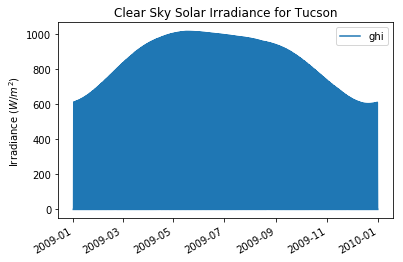

In [49]:
import matplotlib.pyplot as plt
# cs[.plot();
cs['ghi'].plot();

plt.ylabel('Irradiance ($W/m^2$)');
plt.title('Clear Sky Solar Irradiance for {}'.format(name)); 

plt.legend();

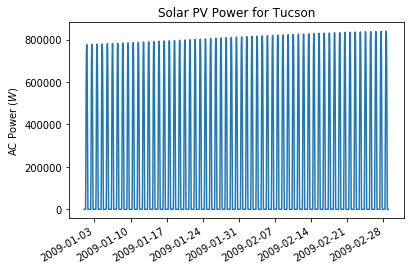

In [50]:
ac['2009-1':'2009-2'].plot();
plt.ylabel('AC Power ($W$)');
plt.title('Solar PV Power for {}'.format(name)); 


In [51]:
df_ac_locs=pd.DataFrame(ac_locs)
df_ac_locs
len(df_ac_locs.columns)
df_ac_magg=pd.DataFrame(ac_mth_agg)
# df_ac_magg
# ac_mth_agg
# len(df_ac_magg.columns)
# NCF_monthly

In [52]:
#######NCF is similar of using only 1 Module 220W
energies = pd.Series(energies)
NCF = pd.Series(NCF)
# based on the parameters specified above, these are in W*hrs
# print(energies.round(0))
decf = {'Energy':energies,'NCF':NCF}
df_E_NCF = pd.DataFrame(decf)
df_E_NCF


,Energy,NCF
Charlotte,2.007125e+09,0.231438
Boulder,2.212071e+09,0.255070
Boston,2.033482e+09,0.234477
Tucson,2.104736e+09,0.242694


Text(0,0.5,'Yearly energy yield (W hr)')

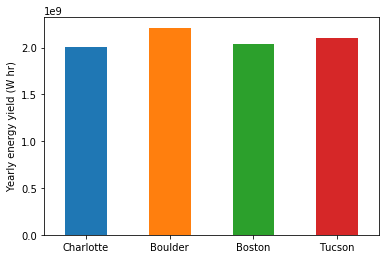

In [53]:
energies.plot(kind='bar', rot=0)

plt.ylabel('Yearly energy yield (W hr)')


In [44]:
energies.head()
ac.head()
# ac.describe()
annual_energy

2104735962.6964245

In [45]:
system_capacity=220
max(ac)

844663.4935509856

In [11]:
# print(ac_mth_agg) 

In [12]:
ac_mth_agg/((740*60)/int(interval) * system_capacity)
#2.135943

2009-01-31 00:00:00-07:00    1015.573984
2009-02-28 00:00:00-07:00    1003.338252
2009-03-31 00:00:00-07:00    1175.831437
2009-04-30 00:00:00-07:00    1137.719013
2009-05-31 00:00:00-07:00    1138.670309
2009-06-30 00:00:00-07:00    1064.769604
2009-07-31 00:00:00-07:00    1099.650905
2009-08-31 00:00:00-07:00    1125.103843
2009-09-30 00:00:00-07:00    1105.659561
2009-10-31 00:00:00-07:00    1106.720664
2009-11-30 00:00:00-07:00     994.183208
2009-12-31 00:00:00-07:00     961.133351
2010-01-31 00:00:00-07:00      -0.000553
Freq: M, dtype: float64

In [13]:
NCF_monthly

{'Charlotte':                                      0
 2009-01-31 00:00:00-04:00   950.318773
 2009-02-28 00:00:00-04:00   973.923862
 2009-03-31 00:00:00-04:00  1112.771242
 2009-04-30 00:00:00-04:00  1087.852514
 2009-05-31 00:00:00-04:00  1099.482395
 2009-06-30 00:00:00-04:00  1029.718440
 2009-07-31 00:00:00-04:00  1065.233627
 2009-08-31 00:00:00-04:00  1068.402148
 2009-09-30 00:00:00-04:00  1061.784270
 2009-10-31 00:00:00-04:00  1063.363866
 2009-11-30 00:00:00-04:00   931.608121
 2009-12-31 00:00:00-04:00   884.319539
 2010-01-31 00:00:00-04:00    -0.000553,
 'Boulder':                                      0
 2009-01-31 00:00:00-06:00  1031.104180
 2009-02-28 00:00:00-06:00  1043.848260
 2009-03-31 00:00:00-06:00  1239.594830
 2009-04-30 00:00:00-06:00  1211.692978
 2009-05-31 00:00:00-06:00  1212.333604
 2009-06-30 00:00:00-06:00  1150.532700
 2009-07-31 00:00:00-06:00  1197.937714
 2009-08-31 00:00:00-06:00  1215.621199
 2009-09-30 00:00:00-06:00  1164.655371
 2009-10-31 00: